# Finetuning of ImageNet pretrained EfficientNet-B0 on CIFAR-100

In 2019, new ConvNets architectures have been proposed in ["EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks"](https://arxiv.org/pdf/1905.11946.pdf) paper. According to the paper, model's compound scaling starting from a 'good' baseline provides an network that achieves  state-of-the-art on  ImageNet,  while  being 8.4x  smaller and 6.1x faster on inference than the best existing ConvNet.

![efficientnets](https://github.com/abdulelahsm/ignite/blob/update-tutorials/examples/notebooks/assets/efficientnets.png?raw=1)

Following the paper, EfficientNet-B0 model pretrained on ImageNet and finetuned on CIFAR100 dataset gives 88% test accuracy. Let's reproduce this result with Ignite. [Official implementation](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet) of EfficientNet uses Tensorflow, 
for our case we will borrow the code from [katsura-jp/efficientnet-pytorch](https://github.com/katsura-jp/efficientnet-pytorch), 
[rwightman/pytorch-image-models](https://github.com/rwightman/pytorch-image-models) and [lukemelas/EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch/) repositories (kudos to authors!). We will download pretrained weights from [lukemelas/EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch/) repository.

## Network architecture review
The architecture of EfficientNet-B0 is the following:
```
1 - Stem    - Conv3x3|BN|Swish

2 - Blocks  - MBConv1, k3x3 
            - MBConv6, k3x3 repeated 2 times
            - MBConv6, k5x5 repeated 2 times
            - MBConv6, k3x3 repeated 3 times
            - MBConv6, k5x5 repeated 3 times
            - MBConv6, k5x5 repeated 4 times
            - MBConv6, k3x3
                            totally 16 blocks

3 - Head    - Conv1x1|BN|Swish 
            - Pooling
            - Dropout
            - FC
```

where 
```
Swish(x) = x * sigmoid(x)
```
and `MBConvX` stands for mobile inverted bottleneck convolution, X - denotes expansion ratio:
``` 
MBConv1 : 
  -> DepthwiseConv|BN|Swish -> SqueezeExcitation -> Conv|BN

MBConv6 : 
  -> Conv|BN|Swish -> DepthwiseConv|BN|Swish -> SqueezeExcitation -> Conv|BN

MBConv6+IdentitySkip : 
  -.-> Conv|BN|Swish -> DepthwiseConv|BN|Swish -> SqueezeExcitation -> Conv|BN-(+)->
   \___________________________________________________________________________/
```

## Installations

1) Torchvision

Please install torchvision in order to get CIFAR100 dataset: 
```
conda install -y torchvision -c pytorch
```

2) Let's install Nvidia/Apex package:

We will train with automatic mixed precision using [nvidia/apex](https://github.com/NVIDIA/apex) pacakge

In [10]:
# Install Apex:
!pip install --upgrade --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" git+https://github.com/NVIDIA/apex/

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
  Cloning https://github.com/NVIDIA/apex/ to /tmp/pip-req-build-qx1u6roj
  Running command git clone -q https://github.com/NVIDIA/apex/ /tmp/pip-req-build-qx1u6roj
  Running command git submodule update --init --recursive -q
Skipping wheel build for apex, due to binaries being disabled for it.
    Running setup.py install for apex ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-req-build-qx1u6roj/setup.py'"'"'; __file__='"'"'/tmp/pip-req-build-qx1u6roj/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' --cpp_ext --cuda_ext install --

3) Install tensorboardX and `pytorch-ignite`

In [11]:
!pip install pytorch-ignite tensorboardX

In [12]:
import random
import torch
import ignite

seed = 17
random.seed(seed)
_ = torch.manual_seed(seed)

In [13]:
torch.__version__, ignite.__version__

('1.8.1+cu101', '0.4.4')

## Model


Let's define some helpful modules:
- Flatten 
- Swish 

The reason why Swish is not implemented in `torch.nn` can be found [here](https://github.com/pytorch/pytorch/pull/3182).


In [14]:
import torch
import torch.nn as nn


class Swish(nn.Module):
    
    def forward(self, x):
        return x * torch.sigmoid(x)


class Flatten(nn.Module):
    
    def forward(self, x):
        return x.reshape(x.shape[0], -1)


Let's visualize Swish transform vs ReLU:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  after removing the cwd from sys.path.


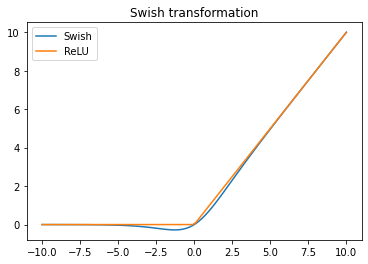

In [15]:
import matplotlib.pylab as plt
%matplotlib inline

d = torch.linspace(-10.0, 10.0)
s = Swish()
res = s(d)
res2 = torch.relu(d)

plt.title("Swish transformation")
plt.plot(d.numpy(), res.numpy(), label='Swish')
plt.plot(d.numpy(), res2.numpy(), label='ReLU')
plt.legend()

Now let's define `SqueezeExcitation` module

In [16]:
class SqueezeExcitation(nn.Module):
    
    def __init__(self, inplanes, se_planes):
        super(SqueezeExcitation, self).__init__()
        self.reduce_expand = nn.Sequential(
            nn.Conv2d(inplanes, se_planes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            Swish(),
            nn.Conv2d(se_planes, inplanes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_se = torch.mean(x, dim=(-2, -1), keepdim=True)
        x_se = self.reduce_expand(x_se)
        return x_se * x


Next, we can define `MBConv`.

**Note on implementation**: in Tensorflow (and PyTorch ports) convolutions use `SAME` padding option which in PyTorch requires
a specific padding computation and additional operation to apply. We will use built-in padding argument of the convolution.

In [17]:
from torch.nn import functional as F


class MBConv(nn.Module):

    def __init__(self, inplanes, planes, kernel_size, stride, 
                 expand_rate=1.0, se_rate=0.25, 
                 drop_connect_rate=0.2):
        super(MBConv, self).__init__()

        expand_planes = int(inplanes * expand_rate)
        se_planes = max(1, int(inplanes * se_rate))

        self.expansion_conv = None        
        if expand_rate > 1.0:
            self.expansion_conv = nn.Sequential(
                nn.Conv2d(inplanes, expand_planes, 
                          kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
                Swish()
            )
            inplanes = expand_planes

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(inplanes, expand_planes,
                      kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size // 2, groups=expand_planes,
                      bias=False),
            nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
            Swish()
        )

        self.squeeze_excitation = SqueezeExcitation(expand_planes, se_planes)
        
        self.project_conv = nn.Sequential(
            nn.Conv2d(expand_planes, planes, 
                      kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(planes, momentum=0.01, eps=1e-3),
        )

        self.with_skip = stride == 1
        self.drop_connect_rate = torch.tensor(drop_connect_rate, requires_grad=False)
    
    def _drop_connect(self, x):        
        keep_prob = 1.0 - self.drop_connect_rate
        drop_mask = torch.rand(x.shape[0], 1, 1, 1) + keep_prob
        drop_mask = drop_mask.type_as(x)
        drop_mask.floor_()
        return drop_mask * x / keep_prob
        
    def forward(self, x):
        z = x
        if self.expansion_conv is not None:
            x = self.expansion_conv(x)

        x = self.depthwise_conv(x)
        x = self.squeeze_excitation(x)
        x = self.project_conv(x)
        
        # Add identity skip
        if x.shape == z.shape and self.with_skip:            
            if self.training and self.drop_connect_rate is not None:
                self._drop_connect(x)
            x += z
        return x

And finally, we can implement generic `EfficientNet`:

In [18]:
from collections import OrderedDict
import math


def init_weights(module):    
    if isinstance(module, nn.Conv2d):    
        nn.init.kaiming_normal_(module.weight, a=0, mode='fan_out')
    elif isinstance(module, nn.Linear):
        init_range = 1.0 / math.sqrt(module.weight.shape[1])
        nn.init.uniform_(module.weight, a=-init_range, b=init_range)
        
        
class EfficientNet(nn.Module):
        
    def _setup_repeats(self, num_repeats):
        return int(math.ceil(self.depth_coefficient * num_repeats))
    
    def _setup_channels(self, num_channels):
        num_channels *= self.width_coefficient
        new_num_channels = math.floor(num_channels / self.divisor + 0.5) * self.divisor
        new_num_channels = max(self.divisor, new_num_channels)
        if new_num_channels < 0.9 * num_channels:
            new_num_channels += self.divisor
        return new_num_channels

    def __init__(self, num_classes=100, 
                 width_coefficient=1.0,
                 depth_coefficient=1.0,
                 se_rate=0.25,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2):
        super(EfficientNet, self).__init__()
        
        self.width_coefficient = width_coefficient
        self.depth_coefficient = depth_coefficient
        self.divisor = 8
                
        list_channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        list_channels = [self._setup_channels(c) for c in list_channels]
                
        list_num_repeats = [1, 2, 2, 3, 3, 4, 1]
        list_num_repeats = [self._setup_repeats(r) for r in list_num_repeats]        
        
        expand_rates = [1, 6, 6, 6, 6, 6, 6]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_sizes = [3, 3, 5, 3, 5, 5, 3]

        # Define stem:
        self.stem = nn.Sequential(
            nn.Conv2d(3, list_channels[0], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(list_channels[0], momentum=0.01, eps=1e-3),
            Swish()
        )
        
        # Define MBConv blocks
        blocks = []
        counter = 0
        num_blocks = sum(list_num_repeats)
        for idx in range(7):
            
            num_channels = list_channels[idx]
            next_num_channels = list_channels[idx + 1]
            num_repeats = list_num_repeats[idx]
            expand_rate = expand_rates[idx]
            kernel_size = kernel_sizes[idx]
            stride = strides[idx]
            drop_rate = drop_connect_rate * counter / num_blocks
            
            name = "MBConv{}_{}".format(expand_rate, counter)
            blocks.append((
                name,
                MBConv(num_channels, next_num_channels, 
                       kernel_size=kernel_size, stride=stride, expand_rate=expand_rate, 
                       se_rate=se_rate, drop_connect_rate=drop_rate)
            ))
            counter += 1
            for i in range(1, num_repeats):                
                name = "MBConv{}_{}".format(expand_rate, counter)
                drop_rate = drop_connect_rate * counter / num_blocks                
                blocks.append((
                    name,
                    MBConv(next_num_channels, next_num_channels, 
                           kernel_size=kernel_size, stride=1, expand_rate=expand_rate, 
                           se_rate=se_rate, drop_connect_rate=drop_rate)                                    
                ))
                counter += 1
        
        self.blocks = nn.Sequential(OrderedDict(blocks))
        
        # Define head
        self.head = nn.Sequential(
            nn.Conv2d(list_channels[-2], list_channels[-1], 
                      kernel_size=1, bias=False),
            nn.BatchNorm2d(list_channels[-1], momentum=0.01, eps=1e-3),
            Swish(),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(list_channels[-1], num_classes)
        )

        self.apply(init_weights)
        
    def forward(self, x):
        f = self.stem(x)
        f = self.blocks(f)
        y = self.head(f)
        return y

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [24]:
print(device)

cuda:0


All EfficientNet models can be defined using the following parametrization:
```
# (width_coefficient, depth_coefficient, resolution, dropout_rate)
'efficientnet-b0': (1.0, 1.0, 224, 0.2),
'efficientnet-b1': (1.0, 1.1, 240, 0.2),
'efficientnet-b2': (1.1, 1.2, 260, 0.3),
'efficientnet-b3': (1.2, 1.4, 300, 0.3),
'efficientnet-b4': (1.4, 1.8, 380, 0.4),
'efficientnet-b5': (1.6, 2.2, 456, 0.4),
'efficientnet-b6': (1.8, 2.6, 528, 0.5),
'efficientnet-b7': (2.0, 3.1, 600, 0.5),
```    
Let's define and train the third one: `EfficientNet-B0`

In [13]:
model = EfficientNet(num_classes=1, 
                     width_coefficient=2.0, depth_coefficient=3.1, 
                     dropout_rate=0.5).to(device)

In [19]:

import torch
import torch.nn as nn
from math import ceil
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import  DataLoader
import torchvision.datasets as datasetes
import torchvision.transforms as transforms

In [20]:
import os
import  pandas as pd
from torch.utils.data import Dataset
#from skimage import io
from PIL import Image

In [21]:

class cancer_data(Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.annot= pd.read_csv(csv_file)
        self.root_dir=root_dir
        self.transform=transform

    def __len__(self):
        return len(self.annot)

    def __getitem__(self, index):
        img_path =os.path.join(self.root_dir,self.annot.iloc[index , 0])
        #print(self.annot.iloc[index ,0])
        #print(self.annot.iloc[index, 1])
        #image=io.imread(img_path)
        image=Image.open(img_path)
        image=image.resize((224,224))
        y_label=torch.tensor(int(self.annot.iloc[index , 1]))
        if self.transform:
            image = self.transform(image)

        return (image , y_label)
        #return (torch.from_numpy(image),y_label)

In [17]:

dataset_input=cancer_data(csv_file='/content/drive/MyDrive/rec.csv' , root_dir='/content/drive/MyDrive/img1/img' , transform=transforms.ToTensor())
train_dataset=DataLoader(dataset=dataset_input ,batch_size=16 ,shuffle=True )

In [18]:
criteria= nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),0.001)

In [19]:
for ep in range(15):
    tot_loss=0
    for batch_idx,(data ,target) in enumerate(train_dataset):
         #convert data of image into 2D to 1D
         #print(data.shape)
         #print(target)
         #print(batch_idx)
         if batch_idx%66==0:
            print("=",end=" ")
         #print(target)
         #forward i.e pass obtain data to algorithm
         data=data.to(device)
         scores=model(data)
         #print(scores)
         target=target.to(device)
         target = target.unsqueeze(1)
         target =target.float()
         loss=criteria(scores,target)
         #print(loss)
         tot_loss+=loss
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
    print("Epoch {}/{}".format(ep + 1, 15))

= = = = = = = = = = = Epoch 1/15
= = = = = = = = = = = Epoch 2/15
= = = = = = = = = = = Epoch 3/15
= = = = = = = = = = = Epoch 4/15
= = = = = = = = = = = Epoch 5/15
= = = = = = = = = = = Epoch 6/15
= = = = = = = = = = = Epoch 7/15
= = = = = = = = = = = Epoch 8/15
= = = = = = = = = = = Epoch 9/15
= = = = = = = = = = = Epoch 10/15
= = = = = = = = = = = Epoch 11/15
= = = = = = = = = = = Epoch 12/15
= = = = = = = = = = = Epoch 13/15
= = = = = = = = = = = Epoch 14/15
= = = = = = = = = = = Epoch 15/15


In [20]:
torch.save(model,'Efficientnetb0007.h5')

In [6]:
import torchvision.transforms as transforms

In [25]:
transform=transforms.ToTensor()
model = torch.load('Efficientnetb0007.h5',map_location=torch.device('cuda'))
model.eval()
import  pandas as pd
df=pd.read_csv('/content/drive/MyDrive/benign.csv')
DF=df.iloc[1:,0:2]
#print(DF)
total=DF.count()[0]
tp=tn=fp=fn=0
for i in range(total):
    if(i!=0 and i%100==0):
        print("=",end=" ")
    image = Image.open('/content/drive/MyDrive/benign1/benign/'+str(DF.iloc[i][0]))
    image = image.resize((224, 224))
    image = transform(image)
    target=int(DF.iloc[i][1])
    x = image.unsqueeze(0)
    out = model(x.to(device))
    n = float(out.data[0][0]) >= 0.5
    if(n and target==1):
        tp+=1
    if(n and target==0):
        fp+=1
    if(not n and target==1):
        fn+=1
    if(not n and target==0):
        tn+=1
print("= = = = = = = = = =")
print("True Positive: "+str(tp))
print("True Negative: "+str(tn))
print("False Positive:"+str(fp))
print("False Negative:"+str(fn))
Total=tp+tn+fp+fn
acc=((tp+tn)/Total)*100
print("Accuracy :  "+str(acc)+"%")

= = = = = = = = = = = = = = = = = = = = = =
True Positive: 645
True Negative: 408
False Positive:0
False Negative:197
Accuracy :  84.24000000000001%


Number of parameters: